In [1]:
import pandas as pd

from gscore.osw.peakgroups import fetch_peak_groups
from gscore.osw.queries import (
    FETCH_UNSCORED_PEAK_GROUPS,
    FETCH_UNSCORED_PEAK_GROUPS_DECOY_FREE,
    CREATE_GHOSTSCORE_TABLE
)
from gscore.models.denoiser import DenoizingClassifier
from gscore.osw.connection import create_table

In [2]:
osw_path = '/home/aaron/projects/ghost/data/hatlas/openswath/Simon_S1607_248.osw'

In [3]:
peak_groups = fetch_peak_groups(
    host=osw_path,
    query=FETCH_UNSCORED_PEAK_GROUPS
)

In [4]:
peak_groups.peak_groups[0].peak_group['var_xcorr_shape']

0    0.772583
1    0.589491
2    0.552479
3    0.810617
4    0.414042
Name: var_xcorr_shape, dtype: float64

In [5]:
peak_groups.rerank_groups(rerank_keys=['var_xcorr_shape'], ascending=False)

In [6]:
peak_groups.peak_groups[0].peak_group['var_xcorr_shape']

3    0.810617
0    0.772583
1    0.589491
2    0.552479
4    0.414042
Name: var_xcorr_shape, dtype: float64

In [7]:
second_ranking = peak_groups.select_peak_group(
    rank=2,
    rerank_keys=['var_xcorr_shape'], 
    ascending=False
)

In [8]:
second_ranking.target.value_counts()

1.0    104218
0.0    103146
Name: target, dtype: int64

In [9]:
second_ranking['target'] = 0.0

In [10]:
highest_ranking = peak_groups.select_peak_group(
    rank=1,
    rerank_keys=['var_xcorr_shape'], 
    ascending=False
)

In [11]:
noisey_labels = pd.concat(
    [
        highest_ranking,
        #second_ranking
    ]
)

In [12]:
noisey_labels.target.value_counts()

1.0    104227
0.0    103156
Name: target, dtype: int64

In [13]:
from gscore.workflows.denoise import denoise

In [14]:
all_peak_groups = denoise(
        training_data=noisey_labels,
        peak_groups=peak_groups,
        columns=peak_groups.ml_features,
        num_folds=10,
        num_classifiers=250
    )

Training for fold idx=0 training size=186644 testing_size=20739 n_samples=18664 for bagging
Training for fold idx=1 training size=186644 testing_size=20739 n_samples=18664 for bagging
Training for fold idx=2 training size=186644 testing_size=20739 n_samples=18664 for bagging
Training for fold idx=3 training size=186645 testing_size=20738 n_samples=18664 for bagging
Training for fold idx=4 training size=186645 testing_size=20738 n_samples=18664 for bagging
Training for fold idx=5 training size=186645 testing_size=20738 n_samples=18664 for bagging
Training for fold idx=6 training size=186645 testing_size=20738 n_samples=18664 for bagging
Training for fold idx=7 training size=186645 testing_size=20738 n_samples=18664 for bagging
Training for fold idx=8 training size=186645 testing_size=20738 n_samples=18664 for bagging
Training for fold idx=9 training size=186645 testing_size=20738 n_samples=18664 for bagging


In [15]:
all_peak_groups.vote_percentage.value_counts()

0.000    354608
0.004     55388
1.000     34464
0.008     32285
0.012     23043
          ...  
0.756      1076
0.712      1068
0.652      1063
0.660      1058
0.640      1057
Name: vote_percentage, Length: 251, dtype: int64

In [16]:
all_peak_groups

,transition_group_id,feature_id,exp_rt,norm_rt,delta_rt,mz,charge,decoy,peptide_sequence,modified_peptide_sequence,...,var_manhattan_score,var_massdev_score_weighted,var_norm_rt_score,var_xcorr_coelution,var_xcorr_coelution_weighted,var_xcorr_shape,var_xcorr_shape_weighted,var_yseries_score,target,vote_percentage
3,0,8548614234701341429,4227.05,57.6627,88.1648,778.413000,2,0,AAAAAAAAAAAAAAAASAGGK,AAAAAAAAAAAAAAAASAGGK,...,0.999375,3.651938,0.030072,3.126696,1.459442,0.810617,0.743093,6.0,1.0,0.096
0,0,3023809260587732107,4015.70,51.1870,-123.1910,778.413000,2,0,AAAAAAAAAAAAAAAASAGGK,AAAAAAAAAAAAAAAASAGGK,...,0.918827,2.716016,0.034684,5.116549,1.907637,0.772583,0.780455,10.0,1.0,0.532
1,0,4654644004292494820,4353.45,61.9703,214.5670,778.413000,2,0,AAAAAAAAAAAAAAAASAGGK,AAAAAAAAAAAAAAAASAGGK,...,1.018444,7.264212,0.073148,6.012101,0.038501,0.589491,0.822176,6.0,1.0,0.872
2,0,4536578386852593533,4242.24,58.1670,103.3540,778.413000,2,0,AAAAAAAAAAAAAAAASAGGK,AAAAAAAAAAAAAAAASAGGK,...,1.389410,11.155628,0.035115,5.738613,2.756684,0.552479,0.477758,7.0,1.0,0.932
4,0,1544303645555666077,3936.34,48.9537,-202.5510,778.413000,2,0,AAAAAAAAAAAAAAAASAGGK,AAAAAAAAAAAAAAAASAGGK,...,1.268366,3.296539,0.057018,6.220725,2.211979,0.414042,0.560799,8.0,1.0,1.000
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
1036473,217749,830335801640044063,4346.38,61.7273,106.8240,813.937254,2,1,VMTQGVNYGLLYLR,VMTQGVNYGLLYLR,...,1.634783,0.137720,0.033684,8.169047,5.414557,0.239667,0.209055,5.0,0.0,0.004
1036477,217749,446962731839660730,4121.67,54.3016,-117.8820,813.937254,2,1,VMTQGVNYGLLYLR,VMTQGVNYGLLYLR,...,1.771925,3.596574,0.040573,10.941403,8.532222,0.136791,0.049131,2.0,0.0,0.148
1036474,217749,7793088631235569718,4231.77,57.8193,-7.7893,813.937254,2,1,VMTQGVNYGLLYLR,VMTQGVNYGLLYLR,...,1.758020,1.391825,0.005396,9.659844,7.463140,0.135887,0.066367,3.0,0.0,0.128
1036475,217749,1178561238339451171,4489.06,66.6154,249.5090,813.937254,2,1,VMTQGVNYGLLYLR,VMTQGVNYGLLYLR,...,1.454771,0.545334,0.082565,10.777515,8.080338,0.131738,0.107374,3.0,0.0,0.000


In [17]:
highest_ranking_swath_data = all_peak_groups.loc[
    all_peak_groups.groupby(['transition_group_id'])["var_xcorr_shape"].idxmax()
]

In [18]:
highest_ranking_swath_data[
    highest_ranking_swath_data.target == 1.0
].vote_percentage.value_counts()

0.000    34914
0.004     5416
1.000     3726
0.008     3280
0.012     2293
         ...  
0.836      101
0.844      100
0.572       99
0.652       98
0.848       98
Name: vote_percentage, Length: 251, dtype: int64

In [19]:
targets = highest_ranking_swath_data[
    (highest_ranking_swath_data.vote_percentage >= 1.0) &
    (highest_ranking_swath_data.target == 1.0)
].copy()

In [20]:
decoys = highest_ranking_swath_data[
    (highest_ranking_swath_data.vote_percentage < 1.0) &
    (highest_ranking_swath_data.target == 1.0)
].copy()

<ipython-input-21-da7fabd652c3>:22: UserWarning: Matplotlib is currently using module://ipykernel.pylab.backend_inline, which is a non-GUI backend, so cannot show the figure.
  test.show()


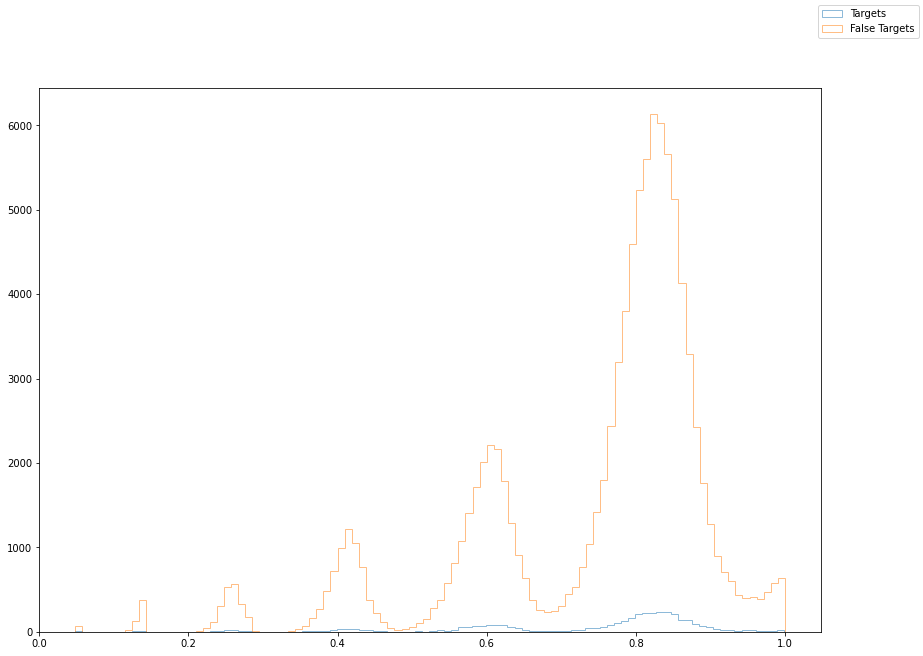

In [21]:
import matplotlib.pyplot as pyplot
from matplotlib.pyplot import figure

test = figure(figsize=(14, 10))

bins = 100

corr_n, corr_bins, _ = pyplot.hist(
    targets['var_xcorr_shape'], bins=bins, histtype='step', alpha=0.5, label='Targets')


incorr_n, incorr_bins, _ = pyplot.hist(
    decoys['var_xcorr_shape'], 
    bins=bins, 
    histtype='step', 
    alpha=0.5, 
    label='False Targets')


test.legend(loc='upper right')
#pyplot.axis([-5, 5, 0, 2000])
test.show()

In [18]:
create_table(osw_path, CREATE_GHOSTSCORE_TABLE)

In [19]:
cutoff = 1.0

In [20]:
record_updates = noisey_labels[
    [
        'feature_id',
        'vote_percentage'
    ]
]

In [21]:
feature_ids = list(record_updates['feature_id'])
votes = list(record_updates['vote_percentage'])

In [23]:
record_updates = list()
for feature_id, vote in zip(feature_ids, votes):
    record_updates.append(
        {'feature_id': feature_id,
         'vote_percentage': vote}
    )

In [25]:
from gscore.osw.connection import OSWConnection

with OSWConnection(osw_path) as conn:
    conn.add_records(
        table_name='ghost_score_table', records=record_updates
    )

# Train model script

In [4]:
from gscore.osw.queries import FETCH_VOTED_DATA

In [6]:
peak_groups = fetch_peak_groups(host=osw_path, query=FETCH_VOTED_DATA)

In [7]:
peak_groups.rerank_groups(rerank_keys=['var_xcorr_shape'], ascending=False)

In [8]:
highest_ranking = peak_groups.select_peak_group(
    rank=1,
    rerank_keys=['var_xcorr_shape'], 
    ascending=False
)

In [9]:
highest_ranking.target.value_counts()

1.0    104227
Name: target, dtype: int64

In [11]:
cutoff = 1.0

In [12]:
targets = highest_ranking[
    (highest_ranking['vote_percentage'] >= cutoff)
].copy()

In [13]:
import tensorflow as tf

from tensorflow import keras

from sklearn.model_selection import train_test_split

import matplotlib.pyplot as plt

In [14]:
decoys = highest_ranking[
    (highest_ranking['vote_percentage'] < cutoff)
].copy()

In [15]:
decoys['target'] = 0.0
targets['target'] = 1.0

In [16]:
target_data = pd.concat([targets, decoys])

In [17]:
target_data.target.value_counts()

1.0    59617
0.0    44610
Name: target, dtype: int64

In [18]:
training_data, testing_data = train_test_split(target_data, test_size=0.1, random_state=42)

In [19]:
training_data.target.value_counts()

1.0    53534
0.0    40270
Name: target, dtype: int64

In [20]:
def preprocess_data(pipeline, data, columns, train=False):
    
    if train == True:
        
        data[columns] = pipeline.fit_transform(data[columns])
        
        return data, pipeline
        
    else:
        
        data[columns] = pipeline.transform(data[columns])
        return data
        
    

In [22]:
from gscore.models.preprocess import STANDARD_SCALAR_PIPELINE

In [26]:
scaling_pipeline = STANDARD_SCALAR_PIPELINE

In [27]:
training_processed, scaling_pipeline = preprocess_data(
    pipeline=scaling_pipeline,
    data=training_data.copy(),
    columns=peak_groups.ml_features,
    train=True
)

In [28]:
import pickle

with open('scalers/standard_scaler.pkl', 'wb') as pkl:
    pickle.dump(scaling_pipeline, pkl)

In [29]:
testing_processed = preprocess_data(
    pipeline=scaling_pipeline,
    data=testing_data.copy(),
    columns=peak_groups.ml_features,
)

In [34]:
from functools import partial


RegularizedDense = partial(
    keras.layers.Dense,
    activation='elu',
    kernel_initializer='he_normal',
    kernel_regularizer=keras.regularizers.l2()
)

optimizer = keras.optimizers.Adam()

early_stopping_cb = keras.callbacks.EarlyStopping(patience=2,
                                                  restore_best_weights=True)

model = keras.models.Sequential([
    RegularizedDense(30, input_shape=training_processed[peak_groups.ml_features].shape[1:]),
    #keras.layers.Dropout(0.2),
    RegularizedDense(30),
    #keras.layers.Dropout(0.1),
    RegularizedDense(30),
    #keras.layers.Dropout(0.1),
    RegularizedDense(30),
    keras.layers.Dense(1, activation='linear')
])

model.compile(loss='binary_crossentropy',
              optimizer=optimizer,
              metrics=['accuracy']
)


In [61]:
ADAM_OPTIMIZER = keras.optimizers.Adam()

EARLY_STOPPING_CB = keras.callbacks.EarlyStopping(
    patience=2,
    restore_best_weights=True
)

class TargetScoringModel(keras.Model):

    RegularizedDense = partial(
        keras.layers.Dense,
        activation='elu',
        kernel_initializer='he_normal',
        kernel_regularizer=keras.regularizers.l2(),
        dtype='float64'
    )

    def __init__(self, input_dim, **kwargs):
        super().__init__(**kwargs)
        self.dense_1 = self.RegularizedDense(30, input_shape=input_dim)
        self.dense_2 = self.RegularizedDense(30)
        self.dense_3 = self.RegularizedDense(30)
        self.dense_4 = self.RegularizedDense(30)
        self.score_output = keras.layers.Dense(1, activation='linear', dtype='float64')

    def call(self, inputs):
        x = self.dense_1(inputs)
        x = self.dense_2(x)
        x = self.dense_3(x)
        x = self.dense_4(x)
        return self.score_output(x)

In [62]:
input_shape = training_processed[peak_groups.ml_features].shape[1:]

In [63]:
model = TargetScoringModel(input_dim=input_shape)

In [64]:
model.compile(loss='binary_crossentropy',
              optimizer=ADAM_OPTIMIZER,
              metrics=['accuracy']
)

In [65]:
history = model.fit(
    training_processed[peak_groups.ml_features], 
    training_processed['target'],
    epochs=20,
    validation_split=0.10,
    callbacks=[EARLY_STOPPING_CB],
    batch_size=32
)

Epoch 1/20

If you intended to run this layer in float32, you can safely ignore this warning. If in doubt, this warning is likely only an issue if you are porting a TensorFlow 1.X model to TensorFlow 2.

To change all layers to have dtype float64 by default, call `tf.keras.backend.set_floatx('float64')`. To change just this layer, pass dtype='float64' to the layer constructor. If you are the author of this layer, you can disable autocasting by passing autocast=False to the base Layer constructor.

2639/2639 [==============================] - 2s 724us/step - loss: 4.8731 - accuracy: 0.7586 - val_loss: 3.5998 - val_accuracy: 0.8467
Epoch 2/20
2639/2639 [==============================] - 2s 704us/step - loss: 3.2424 - accuracy: 0.8464 - val_loss: 2.5369 - val_accuracy: 0.8694
Epoch 3/20
2639/2639 [==============================] - 2s 816us/step - loss: 6.2319 - accuracy: 0.6596 - val_loss: 4.8023 - val_accuracy: 0.7477
Epoch 4/20
2639/2639 [==============================] - 2s 755us/step 

In [66]:
model.evaluate(testing_processed[peak_groups.ml_features], testing_processed['target'])

326/326 [==============================] - 0s 447us/step - loss: 0.1346 - accuracy: 0.9753


[0.13457804918289185, 0.9753429889678955]

In [58]:
model.save('models/hatlas.0.1.test')

INFO:tensorflow:Assets written to: models/hatlas.0.1.test/assets


In [59]:
scoring_model = keras.models.load_model('models/hatlas.0.1.test')

In [60]:
peak_groups = fetch_decoy_free(voted_data)

NameError: name 'fetch_decoy_free' is not defined

In [61]:
all_peak_groups = peak_groups.select_peak_group(
    return_all=True
)

In [62]:
all_peak_groups['d_score'] = scoring_model.predict(all_peak_groups[peak_groups.ml_features]).ravel()

In [63]:
all_peak_groups['vote_percentage'] = all_peak_groups['vote_percentage'].fillna(0.000)

In [64]:
import numpy as np

In [65]:
all_peak_groups['alt_d_score'] = np.exp(all_peak_groups['vote_percentage']) * all_peak_groups['d_score']

In [66]:
all_peak_groups['alt_d_score']

0        -1.917926
1        -1.710281
2        -0.560479
3         0.501129
4        -0.227804
            ...   
520911    0.240733
520912    0.524230
520913    0.572161
520914    0.985711
520915    0.156030
Name: alt_d_score, Length: 520916, dtype: float64

In [68]:
highest_ranking_peak_groups = all_peak_groups.loc[
    all_peak_groups.groupby(['transition_group_id'])['alt_d_score'].idxmax()
]

In [73]:
targets = highest_ranking_peak_groups.loc[
    highest_ranking_peak_groups['vote_percentage'] >= cutoff
].copy()

In [74]:
decoys = highest_ranking_peak_groups.loc[
    highest_ranking_peak_groups['vote_percentage'] < cutoff
].copy()

In [76]:
decoys['target'] = 0.0

In [77]:
all_peak_groups = pd.concat([targets, decoys])

In [78]:
all_peak_groups.target.value_counts()

0.0    82580
1.0    21647
Name: target, dtype: int64

<ipython-input-80-b4fa81556da3>:34: UserWarning: Matplotlib is currently using module://ipykernel.pylab.backend_inline, which is a non-GUI backend, so cannot show the figure.
  test.show()


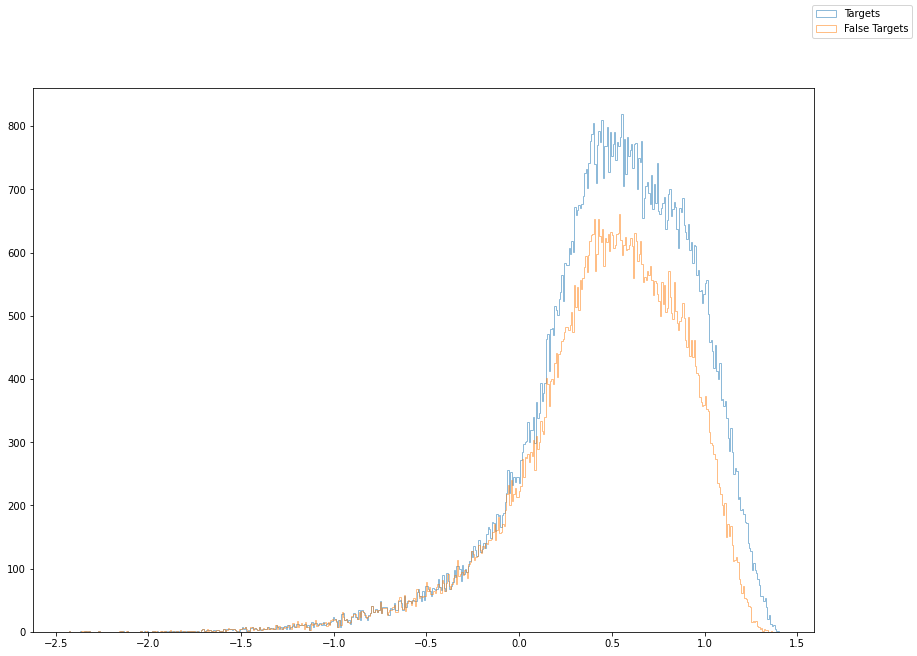

In [80]:
import matplotlib.pyplot as pyplot
from matplotlib.pyplot import figure

test = figure(figsize=(14, 10))

bins = 500

corr_n, corr_bins, _ = pyplot.hist(
    all_peak_groups['d_score'], bins=bins, histtype='step', alpha=0.5, label='Targets')


incorr_n, incorr_bins, _ = pyplot.hist(
    all_peak_groups[
        all_peak_groups['target'] == 0.0
    ]['d_score'], 
    bins=bins, 
    histtype='step', 
    alpha=0.5, 
    label='False Targets')

# pyplot.hist(
#     scoring_target_data[
#         scoring_target_data['target'] == 0.0
#     ]['altered_score'], 
#     bins=bins, 
#     histtype='step', 
#     alpha=0.5, 
#     label='Decoys')



test.legend(loc='upper right')
#pyplot.axis([-5, 5, 0, 2000])
test.show()